# MAC0318 - Teoria de controle - Notebook 1

*Pré-requisitos*: 
- **Software**: Para rodar este notebook corretamente, você deve ter o Python na versão 3.9 ou mais recente e a biblioteca NumPy instalada. Antes de começar, assegure-se de que essas condições são satisfeitas.
- **Conhecimento**: Esta atividade assume familiaridade com o uso de notebooks Jupyter, manipulação de matrizes usando a bilbioteca NumPy e conhecimentos básicos de modelagem de sistemas de controle. Recomendamos seguir algum tutorial da internet antes de realizar essa atividade, se esse não for o seu caso. 

<span style="color:blue">Se você está rodando o notebook em sala de aula, você deve ativar o ambiente `duckievillage` antes de abrir o jupyter notebook e escolher o kernel `duckievillage`, para que os requerimentos sejam satisfeitos.</red>

# Controle PID

Um controlador emite sinals de comando que são executados pelo robô visando atingir um objetivo. No caso do robô diferencial, os sinais de controle são os valores de tensão elétrica enviados para cada roda. 
É mais simples no entanto projetar controladores que controlam diretamente a velocidade $v$ e a orientação $\omega$ do robô. Para um dado sinal de controle $u=\begin{bmatrix} v & \omega \end{bmatrix}$, podemos encontrar os valores de controle de tensão para cada roda resolvendo os sistema de equação abaixo.

$$
\begin{bmatrix} v \\ \omega \end{bmatrix} = K_m \frac{R}{2} \begin{bmatrix} 1 & 1 \\ \frac{1}{L} & -\frac{1}{L} \end{bmatrix} \begin{bmatrix} \varphi_l \\ \varphi_r \end{bmatrix}
$$

na qual $K_m$ é uma constante que relaciona a velocidade angular à tensão dos motores. Tal constante pode ser estimada empiricamente ou simplesmente ignorada para o projeto de um controlador PID (e considerada embutida nas constantes do projeto, como veremos a seguir).

O controlador **P**roporcional-**I**ntegral-**D**erivativo (PID) é um controlador retroalimentado que usa a saída $y(t)$ do sistema para medir o erro de trajetória $e(t)$ com relação a um sinal de referência $r(t)$ e produzir um sinal de controle $u(t)$ que busque reduzir o erro.

<figure>
  <div style="text-align:center;">
  <img src="img/pid-control-diagram.jpg" alt="pid-loop-2" style="width: 300px;"/>
  <figcaption>Controle PID</figcaption>
  </div>
</figure>

A parte proporcional relaciona a intensidade do valor de controle à magnitude do erro; a parte derivativa busca antecipar erros. Por fim, a parte integrativa busca minimizar o erro acumulado introduzido pela insuficiência de correção da parte proporcional, além de atenuar ruídos. A equação completa do controlador PID é dada pela soma de cada componente:

$$ u_t = K_p e(t) + K_i \int_0^t e(\tau) d \tau + K_d \frac{d e_t}{dt},$$

com $K_p$, $K_i$, and $K_d$ denotando as constantes a serem especificadas. Existem inúmeras técnicas para projetar tais constantes usando o modelo de malha fechada do sistema e/ou dados experimentais. No entanto, a atratividade do controle PID advém do fato que é possível ajustar tais constantes de maneira completamente empírica (por tentativa e erro) e obter comportamento satisfatório (ainda que subótimo). O procedimento de ajuste em geral consiste em:

1. Encontrar um valor de $K_p$ que torne o sistema controlável assintoticamente estável mas com alguma oscilação, mantendo $K_i=K_d=0$.
2. Ajustar o valor de $K_d$ para diminuir as oscilações sem que o tempo de resposta do sistema se altere significativamente.
3. Por fim, ajustar o valor de $K_i$ para mitigar o erro assintótico.

Note que esse procedimento é puramente heurístico: ele não garante que o sistema controlado seja estável, possua bom desempenho nem seja robusto.

## Seguindo um ponto

Vamos projetar um controlador proporcional para mover o robô a uma posição desejada $G = (x^*, y^*)$. O estado do sistema será a pose $q(t) = \begin{bmatrix} x(t) & y(t) & \theta(t) \end{bmatrix}^t$.

<figure>
  <div style="text-align:center;">
  <img src="img/point_following.png" alt="pid-loop-2" style="width: 300px;"/>
  <figcaption>Controle PID</figcaption>
  </div>
</figure>

A saída do sistema é a distância do centro do referencial local robô (A) ao ponto meta (G) e a diferença entre a orientação do robô e o referencial centrado na meta e paralelo ao referencial fixo:
$$
   y(t) = \begin{bmatrix} d(t) & \alpha(t) \end{bmatrix}^t .
$$
Tais valores podem ser calculados a partir da pose do robô como:
$$
d = \sqrt{ (x^*-x)^2 + (y^*-y)^2 }
$$
e
$$
\alpha = \arctan \frac{y^*-y}{x^*-x} .
$$

In [1]:
# Vamos usar o mesmo simulador da atividade de modelagem
from DifferentialDrive import DifferentialRobot
import numpy as np

## Controlador para seguidor de ponto

Vamos projetar um controlador proporcional para seguir o ponto $G$ através da seguinte regra de controle:
$$
u(t) = \begin{bmatrix} v \\ \omega\end{bmatrix} = \begin{bmatrix} K_d d \\ K_\alpha \alpha \end{bmatrix}
$$

O código abaixo implementa o controlador proporcional de posição.

Experimente modificar as configurações do controlador de posição a seguir, alterando as constantes $K_{d}$ e $K_{\alpha}$, assim como a posição da meta.
Procure notar a relação entre estabilidade e desempenho ao modificar as constantes.

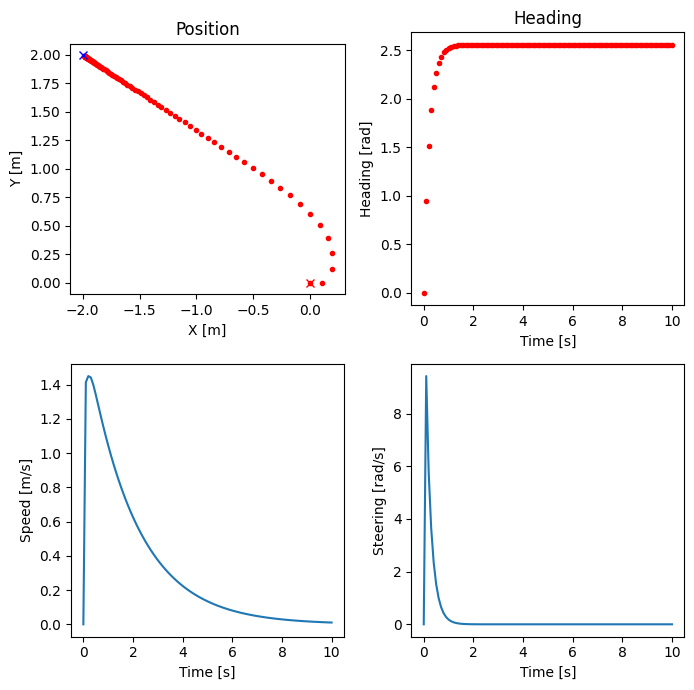

In [2]:
robot = DifferentialRobot()

goal = np.array([-2,2]) # posição da meta

e_p, e_t = [], [] # armazenar valores de erro para geração de gráfico

Kd = 0.5 # constante proporcional para controle de velocidade
Ka = 4.0 # constante proporcional para controle de rotação

for _ in range(100): # simular 100 passos (10s)
    # Calcular erro de posição
    diff = goal-robot.x[:2]
    error_pos = np.sqrt( np.dot(diff, diff) )
    # Calcular erro de orientação
    error_theta = np.arctan2( diff[1], diff[0] ) - robot.x[2]
    e_p.append(error_pos)
    e_t.append(error_theta)
    # Controle proporcional
    speed = Kd*error_pos
    steer = Ka*error_theta
    robot.forward(speed, steer)
fig, axes = robot.plot()
axes[0,0].plot([0],[0], 'rx'); # desenhar início em vermelho
axes[0,0].plot(goal[0],goal[1], 'bx'); # desenhar meta em azul

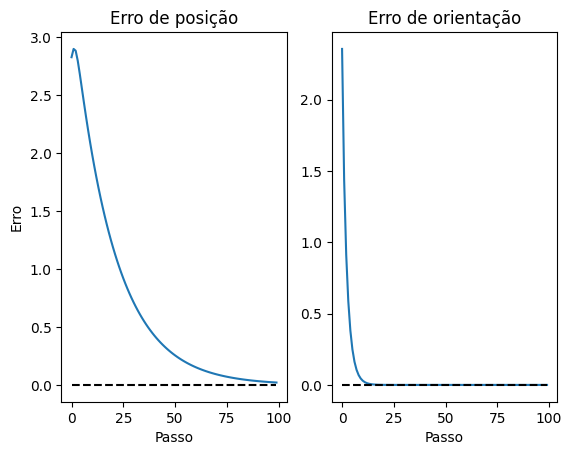

In [3]:
# Rode esse célula para exibir os gráficos de erro por tempo

import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,2)
ax[0].plot(e_p);
ax[0].plot([0,len(e_p)-1], [0,0], 'k--')
ax[0].set_xlabel('Passo');
ax[0].set_ylabel('Erro');
ax[0].set_title('Erro de posição');
ax[1].plot(e_t);
ax[1].plot([0,len(e_t)-1], [0,0], 'k--')
ax[1].set_title('Erro de orientação');
ax[1].set_xlabel('Passo');

Iniciando simulação com controlador PID...
Constantes PID para posição: Kp=0.5, Ki=0.0, Kd=0.1
Constantes PID para orientação: Kp=3.0, Ki=0.1, Kd=0.5
Simulação concluída!


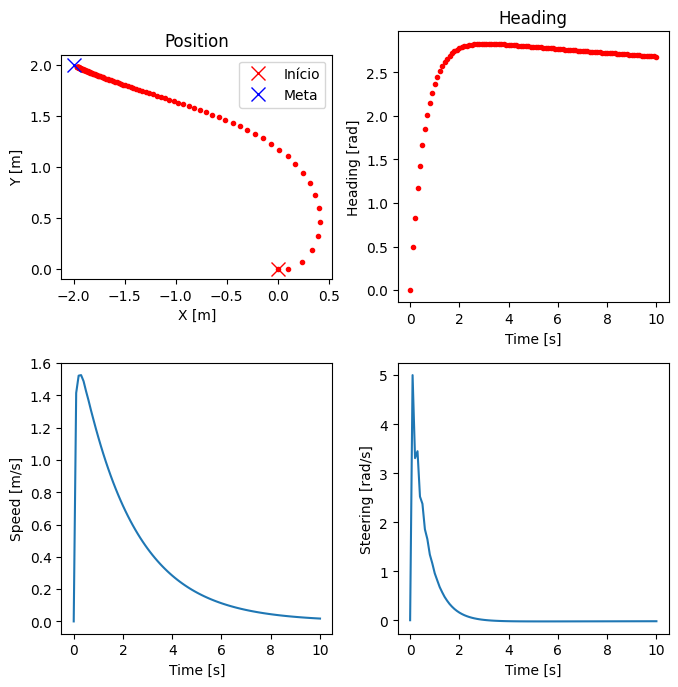

In [16]:
# Solução: Controlador PID Completo

robot = DifferentialRobot()

goal = np.array([-2,2])

e_p, e_t = [], [] # erros de posição e orientação
e_p_int, e_t_int = 0, 0 # integral dos erros (inicializar em 0)
e_p_prev, e_t_prev = 0, 0 # erros anteriores para cálculo da derivada

# cte proporcionais (P)
Kp_pos = 0.5
Kp_theta = 3.0

# cte integrais (I) 
Ki_pos = 0.0
Ki_theta = 0.1

# cte derivativas (D)
Kd_pos = 0.1 
Kd_theta = 0.5

dt = 0.1  # intervalo de tempo (assumindo 100ms por passo)

print("Iniciando simulação com controlador PID...")
print(f"Constantes PID para posição: Kp={Kp_pos}, Ki={Ki_pos}, Kd={Kd_pos}")
print(f"Constantes PID para orientação: Kp={Kp_theta}, Ki={Ki_theta}, Kd={Kd_theta}")

for step in range(100): # simular 100 passos (10s)
    # Calcular erro de posição
    diff = goal - robot.x[:2]
    error_pos = np.sqrt(np.dot(diff, diff))
    
    # Calcular erro de orientação
    error_theta = np.arctan2(diff[1], diff[0]) - robot.x[2]
    
    # Normalizar erro de orientação para [-π, π]
    while error_theta > np.pi:
        error_theta -= 2*np.pi
    while error_theta < -np.pi:
        error_theta += 2*np.pi
    
    # Armazenar erros para análise
    e_p.append(error_pos)
    e_t.append(error_theta)
    
    P_pos = Kp_pos * error_pos
    P_theta = Kp_theta * error_theta
    
    e_p_int += error_pos * dt
    e_t_int += error_theta * dt
    I_pos = Ki_pos * e_p_int
    I_theta = Ki_theta * e_t_int
    
    if step > 0: #derivar apos o primeiro passo
        D_pos = Kd_pos * (error_pos - e_p_prev) / dt
        D_theta = Kd_theta * (error_theta - e_t_prev) / dt
    else:
        D_pos = 0
        D_theta = 0
    
    e_p_prev = error_pos
    e_t_prev = error_theta
    
    speed = P_pos + I_pos + D_pos
    steer = P_theta + I_theta + D_theta
    
    speed = np.clip(speed, -2.0, 2.0)
    steer = np.clip(steer, -5.0, 5.0)
    
    robot.forward(speed, steer)
    

print("Simulação concluída!")

# Plotar trajetória
fig, axes = robot.plot()
axes[0,0].plot([0],[0], 'rx', markersize=10, label='Início'); # desenhar início
axes[0,0].plot(goal[0], goal[1], 'bx', markersize=10, label='Meta'); # desenhar meta
axes[0,0].legend()


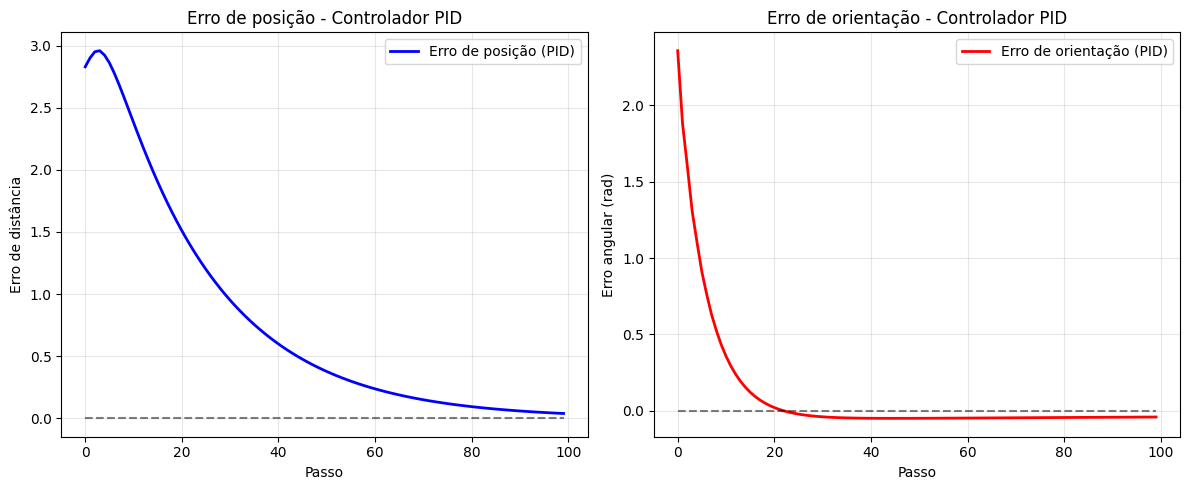

=== ANÁLISE DE DESEMPENHO ===
Erro final de posição: 0.0390
Erro final de orientação: -0.0400 rad
Tempo para convergência (erro < 0.1): 79 passos
Máximo overshoot de posição: 2.9582
Erro RMS de posição: 1.1969


In [17]:
# Visualizar os gráficos de erro do controlador PID

import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,2, figsize=(12, 5))

# Gráfico de erro de posição
ax[0].plot(e_p, 'b-', linewidth=2, label='Erro de posição (PID)');
ax[0].plot([0,len(e_p)-1], [0,0], 'k--', alpha=0.5)
ax[0].set_xlabel('Passo');
ax[0].set_ylabel('Erro de distância');
ax[0].set_title('Erro de posição - Controlador PID');
ax[0].grid(True, alpha=0.3)
ax[0].legend()

# Gráfico de erro de orientação  
ax[1].plot(e_t, 'r-', linewidth=2, label='Erro de orientação (PID)');
ax[1].plot([0,len(e_t)-1], [0,0], 'k--', alpha=0.5)
ax[1].set_title('Erro de orientação - Controlador PID');
ax[1].set_xlabel('Passo');
ax[1].set_ylabel('Erro angular (rad)');
ax[1].grid(True, alpha=0.3)
ax[1].legend()

plt.tight_layout()
plt.show()

# Estatísticas de desempenho
print("=== ANÁLISE DE DESEMPENHO ===")
print(f"Erro final de posição: {e_p[-1]:.4f}")
print(f"Erro final de orientação: {e_t[-1]:.4f} rad")
print(f"Tempo para convergência (erro < 0.1): {next((i for i, err in enumerate(e_p) if err < 0.1), len(e_p))} passos")
print(f"Máximo overshoot de posição: {max(e_p):.4f}")
print(f"Erro RMS de posição: {np.sqrt(np.mean(np.array(e_p)**2)):.4f}")


## 💡 Exercício

Modifique o controlador acima introduzindo as constantes $K_d$ e $K_i$. Para implementar o controle integrativo, você precisa calcular a integral do erro até o instante atual. Como não possuímos uma fórmula fechada para o erro, tal integral só pode ser calculada de forma aproximada.
Uma aproximação simples mas comumente satisfatória é aproximar a integral por uma soma finita:

$$ 
e_{int}(t) = \int_0^t e(\tau) d\tau \simeq \sum_{i=0}^{k} e_i \Delta t = (e_0 + e_1 + \dots + e_{k-1} + e_k)\Delta t .
$$
Na equação acima assumimos que as observações dos erros são uniformemente espaçadas no tempo. É possível escrever equação similar para o caso de espaçamentos não uniformes também. A implementação acima é computacionalmente ineficiente e pode levar a imprecisões numéricas. Uma forma mais conveniente é notar a relação:

$$ 
e_{int,k}= (e_0 + e_1 + \dots + e_{k-1} + e_k)\Delta t = (e_0 + e_1 + \dots + e_{k-1})\Delta t + e_k\Delta t = e_{int,k-1} + e_k \Delta t.
$$
A última equação acima calcula o erro acumulado a partir da observação atual e do erro acumulado anterior.


Realize o procedimento indicado para encontrar valores para as três constantes do controlador PID. Reflita sobre como o comportamento final foi modificado em relação ao controle puramente proporcional. Em particular, note se o tempo até que o erro convirja a zero diminui, se o sistema se tornou mais ou menos estável. Reflita também como você poderia analizar a robustez do sistema.

In [ ]:
robot = DifferentialRobot()

goal = np.array([-2,2]) # posição da meta

e_p, e_t = [], [] # armazenar valores de erro para geração de gráfico

Kp_d = 0.5 # constante para controle proporcional de velocidade
Kp_a = 4.0 # constante para controle proporional de rotação
Kd_d = 0.0 # constante para controle derivativo de velocidade
Kd_a = 0.0 # constante para controle derivativo de rotação
Ki_d = 0.0 # constante para controle integrativo de velocidade
Ki_a = 0.0 # constante para controle integrativo de rotação


for _ in range(100): # simular 100 passos (10s)
    # Calcular erro de posição
    diff = goal-robot.x[:2]
    error_pos = np.sqrt( np.dot(diff, diff) )
    # Calcular erro de orientação
    error_theta = np.arctan2( diff[1], diff[0] ) - robot.x[2]
    e_p.append(error_pos)
    e_t.append(error_theta)
    # Controle PID: completar equações
    speed = Kd*error_pos # + componente derivativo + componente integrattivo
    steer = Ka*error_theta # + ...
    robot.forward(speed, steer)
fig, axes = robot.plot()
axes[0,0].plot([0],[0], 'rx'); # desenhar início em vermelho
axes[0,0].plot(goal[0],goal[1], 'bx'); # desenhar meta em azul